In [59]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
import h5py
import numpy as np
import get_xyz
import constants
from pathlib import Path
import hdf5plugin
import streak_finder as sf
import add_geometry_streaks
import scipy.constants as sc
import scipy.ndimage


def angle_filter(streaks, angle=.1):
    # angle in radians
    x0, y0, x1, y1 = streaks.T
    dx = x1 - x0
    dy = y1 - y0
    
    # filter by angle
    nh = np.array([-dy, dx]) # normal vectors
    nh = nh / (nh[0]**2 + nh[1]**2)**0.5
    
    rh = np.array([x0 + x1, y0 + y1]) / 2 # centre postions
    rh = rh / (rh[0]**2 + rh[1]**2)**0.5
    
    cos = np.sum(rh * nh, axis=0) # cosign of angle bw r0 and rh
    
    m = cos > np.cos(angle)
    return m

def get_streak(streak, file, file_index, window_size=30):
    with h5py.File(file) as f:
        slab = f['/data/JF07T32V02/data'][file_index]

    s = slab.shape
    t = window_size // 2
    i = int(round((streak[1] + streak[3])/2))
    j = int(round((streak[0] + streak[2])/2))
    im = np.zeros((window_size, window_size), dtype=float)
    i0 = max(i - t, 0)
    i1 = min(i + t, s[0])

    j0 = max(j - t, 0)
    j1 = min(j + t, s[1])

    # print(slab.shape, slab[i0: i1, j0: j1].shape, im[:i1-i0, :j1-j0].shape, i0, i1, j0, j1)
    im[:i1-i0, :j1-j0] = slab[i0: i1, j0: j1]
    im[im<0] = 0
    return im / im.max()

def hit_filter(pid, min_streaks=5):
    m = np.zeros(pid.shape, dtype=bool)
    pidu, pid, n_d = np.unique(pid, return_inverse=True, return_counts=True)
    m_d = n_d > min_streaks
    for p in np.where(m_d)[0]:
        print(p)
        m[np.where(pid==p)[0]] = True
    return m

runs = [121]
sample = 'B4C-06'

title = f'typical streaks {sample} {runs=}'
file = f'typical_streaks_{sample}_runs_{'_'.join(str(r) for r in runs)}.svg'

fnams = [Path(constants.work) / f'streaks/streaks_run{run:>04}.h5' for run in runs]

streaks = []
pid = []
files = []
inds = []
for fnam in fnams:
    with h5py.File(fnam) as f:
        streaks.append(f['fs0_ss0_fs1_ss1_slab'][()])
        pid.append(f['pulse_id'][()])
        files.append(f['file_name'][()])
        inds.append(f['file_index'][()])

streaks = np.concatenate(streaks, axis=0)
pid = np.squeeze(np.concatenate(pid, axis=0))
files = np.concatenate(files, axis=0)
inds = np.concatenate(inds, axis=0)

# filter by hits and by angle
m = angle_filter(streaks, np.pi/64)
streaks = streaks[m]
pid = pid[m]
files = files[m]
inds = inds[m]

"""
x0, y0, x1, y1 = streaks.T
dx = x1 - x0
dy = y1 - y0
length = (dx**2 + dy**2)**0.5
m = length > 15
streaks = streaks[m]
pid = pid[m]
files = files[m]
inds = inds[m]

m = hit_filter(pid, 5)
streaks = streaks[m]
pid = pid[m]
files = files[m]
inds = inds[m]
"""


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\nx0, y0, x1, y1 = streaks.T\ndx = x1 - x0\ndy = y1 - y0\nlength = (dx**2 + dy**2)**0.5\nm = length > 15\nstreaks = streaks[m]\npid = pid[m]\nfiles = files[m]\ninds = inds[m]\n\nm = hit_filter(pid, 5)\nstreaks = streaks[m]\npid = pid[m]\nfiles = files[m]\ninds = inds[m]\n'

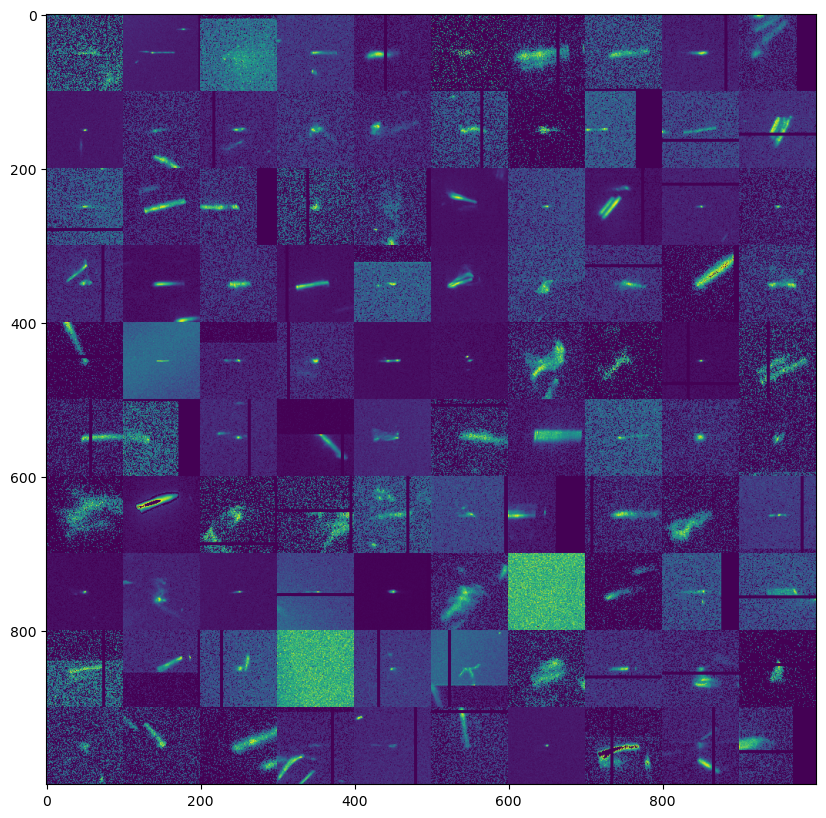

In [60]:
i = np.random.randint(0, inds.shape[0], size=5)
ims = []
for i in range(10):
    ims_row = []
    for d in np.random.randint(0, streaks.shape[0], size=10):
        ims_row.append(get_streak(streaks[d], files[d], inds[d], 100))
    ims.append(np.concatenate(ims_row))

ims = np.concatenate(ims, axis=1)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.imshow(ims**0.5)
plt.show()


In [55]:
x0, y0, x1, y1 = streaks.T
dx = x1 - x0
dy = y1 - y0
length = (dx**2 + dy**2)**0.5

In [56]:
length.min()

np.float64(15.000004606413016)